In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

import missingno as msno
%matplotlib inline

In [2]:
df = pd.read_csv('twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:
df.shape

(74681, 4)

In [4]:
df.sample(7)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
52208,10569,RedDeadRedemption(RDR),Neutral,More Poison Mountain moonshine Recipe searching
47219,5702,HomeDepot,Positive,Me Too by Meghan Trainor is playing at this Ho...
26437,941,AssassinsCreed,Neutral,"On the same day, in 2018, our Creative Directo..."
47082,5678,HomeDepot,Negative,Now that Bernie from Home Depot has said it......
11842,8434,NBA2K,Negative,@NBA2K what’s going on with this shot meter R ...
27420,1122,AssassinsCreed,Positive,Exactly what I said should happen. Epic movie ...
16464,9620,PlayStation5(PS5),Negative,I don't think you've seen the price of the PS5...


### Data Clean 

In [5]:
df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [6]:
## clean column names
df.columns = ["Index", "Land", "Mode", "Text"]
df.head()

,Index,Land,Mode,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df.duplicated().sum()

2700

In [8]:
df.isnull().sum() / df.shape[0]

Index    0.000000
Land     0.000000
Mode     0.000000
Text     0.009186
dtype: float64

In [9]:
def show_details(df):
    missing_values_count = df.isnull().sum()
    missing_values_percent = df.isnull().sum() / df.shape[0]
    duplicates_count = df.duplicated().sum()
    duplicates_percent = df.duplicated().sum() / df.shape[0]
    df_info = pd.DataFrame({"missing_values_count": missing_values_count,
                            "missing_values_percent": missing_values_percent,
                            "duplicates_count": duplicates_count,
                            "duplicates_percent": duplicates_percent})
    return df_info


In [10]:
df_info = show_details(df)
df_info

,missing_values_count,missing_values_percent,duplicates_count,duplicates_percent
Index,0,0.000000,2700,0.036154
Land,0,0.000000,2700,0.036154
Mode,0,0.000000,2700,0.036154
Text,686,0.009186,2700,0.036154


In [11]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
show_details(df)

,missing_values_count,missing_values_percent,duplicates_count,duplicates_percent
Index,0,0.0,0,0.0
Land,0,0.0,0,0.0
Mode,0,0.0,0,0.0
Text,0,0.0,0,0.0


In [12]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

In [13]:
df["Land"].nunique()

32

## EDA

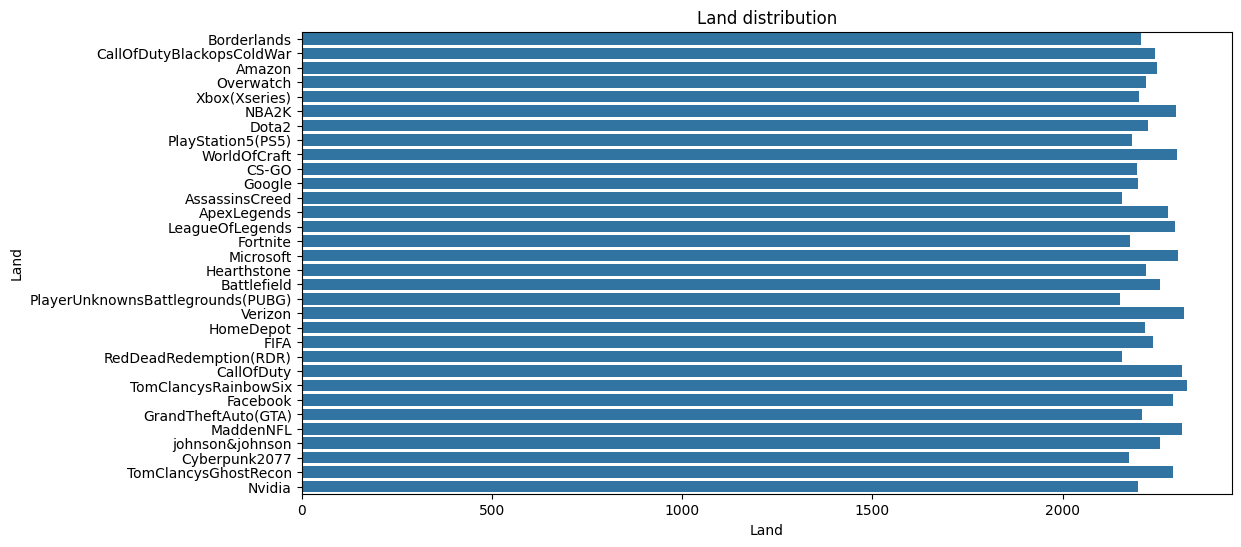

In [14]:
# Land distribution
plt.figure(figsize=(12, 6))
sns.countplot(df["Land"])
plt.xlabel("Land")
plt.title("Land distribution")
plt.show()

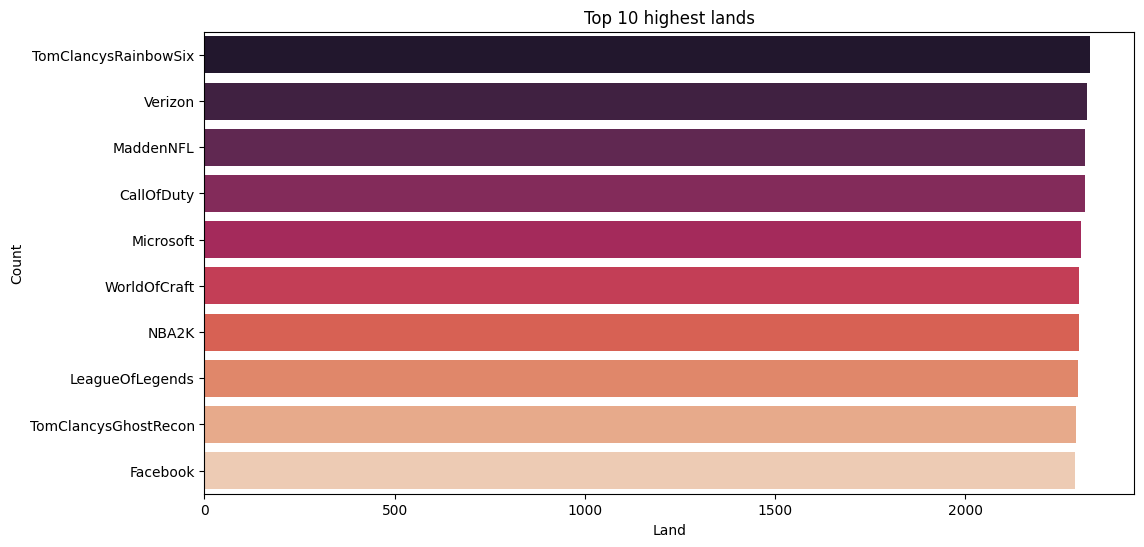

In [15]:
# lands = df["Land"].value_counts()
# lands.to_frame()
# show top 10 highest lands
plt.figure(figsize=(12, 6))
sns.barplot(y=df["Land"].value_counts()[:10].index, x = df["Land"].value_counts()[:10].values, palette='rocket')
plt.xlabel("Land")
plt.ylabel("Count")
plt.title("Top 10 highest lands")
plt.show()


In [16]:
# Mode Analysis
df["Mode"].value_counts()

Mode
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

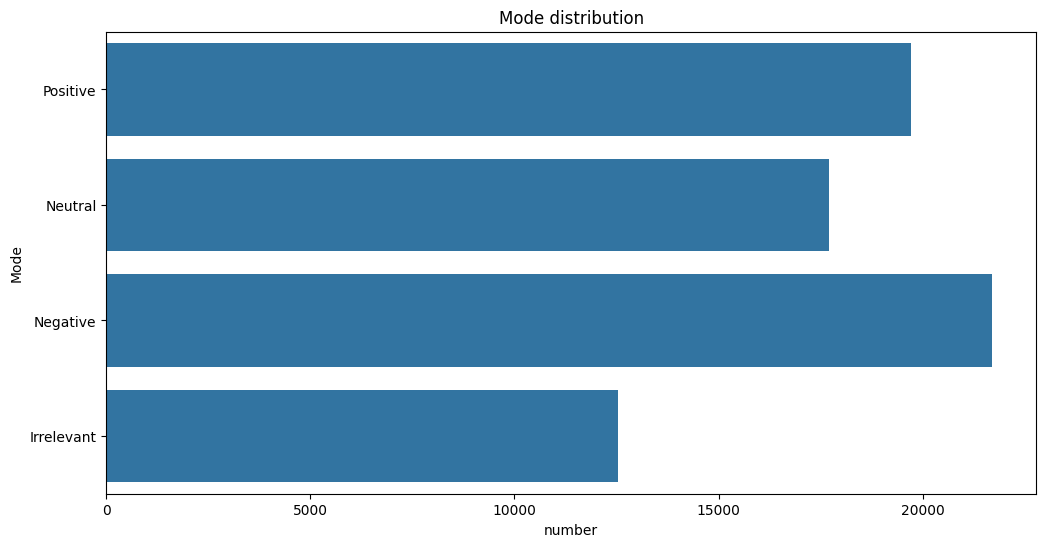

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(df["Mode"])
plt.xlabel("number")
plt.title("Mode distribution")
plt.show()

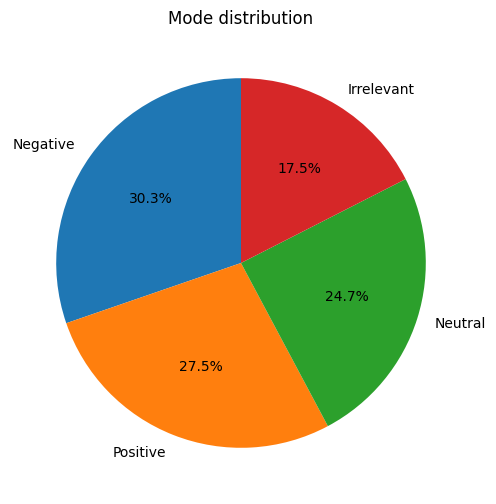

In [18]:
plt.figure(figsize=(12, 6))
plt.pie(df["Mode"].value_counts(), labels=df["Mode"].value_counts().index, autopct='%1.1f%%', startangle=90,
)
plt.title("Mode distribution")
plt.show()


In [19]:
pd.crosstab(df.Land, df.Mode).style\
.background_gradient(subset=["Negative"], cmap="Greens")\
.background_gradient(subset=["Positive"], cmap="Reds")\
.background_gradient(subset=["Irrelevant"], cmap="BuGn")

Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [20]:
df.iloc[10]["Text"]

'was'

### Feature engineering 

In [21]:
import re

stemmer = PorterStemmer()
stopwords_list = stopwords.words("english")


def preprocess_text(text):
    # Dictionary for contractions mapping
    contractions = {
        r"won't": "would not", r"can't": "can not", r"don't": "do not",  r"shouldn't": "should not",
        r"needn't": "need not", r"hasn't": "has not", r"haven't": "have not", r"weren't": "were not",
        r"mightn't": "might not", r"didn't": "did not", r"n't": " not", r"'re": " are", r"'s": " is",
        r"'d": " would", r"'ll": " will", r"'t": " not", r"'ve": " have", r"'m": " am",
        r"\bim\b": "i am", r"\bIm\b": "I am"
    }

    # Apply contractions replacement
    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Keep only letters, numbers, and specific punctuation
    text = re.sub(r'[^a-zA-Z0-9!?@.]', ' ', text)

    # Normalize repeated punctuation
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'@+', '@', text)

    # Remove unwanted tokens & extra spaces
    text = re.sub(r'\bunk\b', ' ', text)  # Remove "unk" as a word
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Convert to lowercase
    text = text.lower()

    # Tokenize text for stemming
    regexp_tokenizer = RegexpTokenizer(r"\w+")
    tokenized_text = regexp_tokenizer.tokenize(text)

    # Apply stemming
    stemmed_words = [stemmer.stem(word) for word in tokenized_text if word not in stopwords_list]



    return " ".join(stemmed_words)


In [22]:
df["cleaned_text"] = df["Text"].apply(lambda x: preprocess_text(x))
df["cleaned_text"]

0                                         come border kill
1                                      get borderland kill
2                                   come borderland murder
3                                  get borderland 2 murder
4                                    get borderland murder
                               ...                        
74676    realiz window partit mac like 6 year behind nv...
74677    realiz mac window partit 6 year behind nvidia ...
74678    realiz window partit mac 6 year behind nvidia ...
74679    realiz window partit mac like 6 year behind nv...
74680    like window partit mac like 6 year behind driv...
Name: cleaned_text, Length: 71655, dtype: object

In [23]:
df.iloc[10]["cleaned_text"]

''

In [24]:
nan_idx = df[df["cleaned_text"] == ""].index
df.drop(nan_idx, inplace=True)

In [25]:
df.shape

(69914, 5)

In [26]:
for i in range(10):
    print(df["cleaned_text"].iloc[i])

come border kill
get borderland kill
come borderland murder
get borderland 2 murder
get borderland murder
spent hour make someth fun know huge borderland fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg
spent coupl hour someth fun know huge borderland fan maya one favorit charact decid make wallpap pc origin pictur compar creation made fun pic twitter com mlsi5wf9jg
spent hour someth fun know huge borderland fan maya one favorit charact
spent hour make someth fun know huge rhandlerr fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg
2010 spent hour make someth fun know huge rhandlerr fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg


In [27]:
df.shape

(69914, 5)

In [28]:
def clean_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols
                           u"\U0001F680-\U0001F6FF"  # transport
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

In [29]:
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: clean_emoji(x))
for i in range(10):
    print(df["cleaned_text"].iloc[i])
# df["cleaned_text"]

come border kill
get borderland kill
come borderland murder
get borderland 2 murder
get borderland murder
spent hour make someth fun know huge borderland fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg
spent coupl hour someth fun know huge borderland fan maya one favorit charact decid make wallpap pc origin pictur compar creation made fun pic twitter com mlsi5wf9jg
spent hour someth fun know huge borderland fan maya one favorit charact
spent hour make someth fun know huge rhandlerr fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg
2010 spent hour make someth fun know huge rhandlerr fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pic twitter com mlsi5wf9jg


In [30]:
df["sentiment"] = df["Mode"].replace({"Negative": 0, "Irrelevant": 1, "Neutral": 1, "Positive": 2})
df["sentiment"]

0        2
1        2
2        2
3        2
4        2
        ..
74676    2
74677    2
74678    2
74679    2
74680    2
Name: sentiment, Length: 69914, dtype: int64

In [31]:
df.shape

(69914, 6)

In [32]:
# df.to_csv("cleaned_twitter_training.csv", index=False)

In [33]:
# new_df = pd.read_csv("cleaned_twitter_training.csv")
# new_df.head()

In [34]:
# nan_idx = new_df[new_df["cleaned_text"].isna()].index
# nan_idx

In [35]:
# random.seed(99)
# text = random.choice(df["Text"])
# text

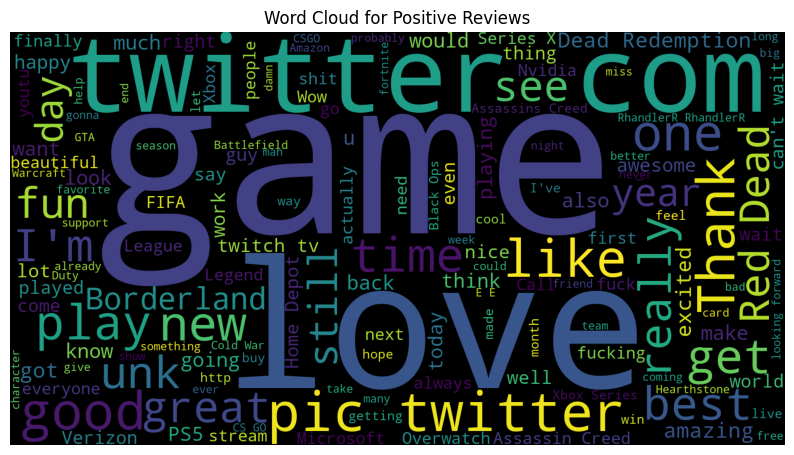

In [36]:
# WordCloud
# %%time

def plot_wordcloud(df, mode="Positive"):

    reviews = df[df['Mode'] == mode]['Text']
    corpus = ' '.join(map(str, reviews))
    corpus_wordcloud = WordCloud(width=1500, height=800,
                            background_color='black',
                            stopwords=stopwords_list,
                            min_font_size=15).generate(corpus)
    plt.figure(figsize=(10, 10))
    plt.imshow(corpus_wordcloud)
    plt.title(f'Word Cloud for {mode} Reviews')
    plt.axis('off')
    plt.show()
plot_wordcloud(df, "Positive")

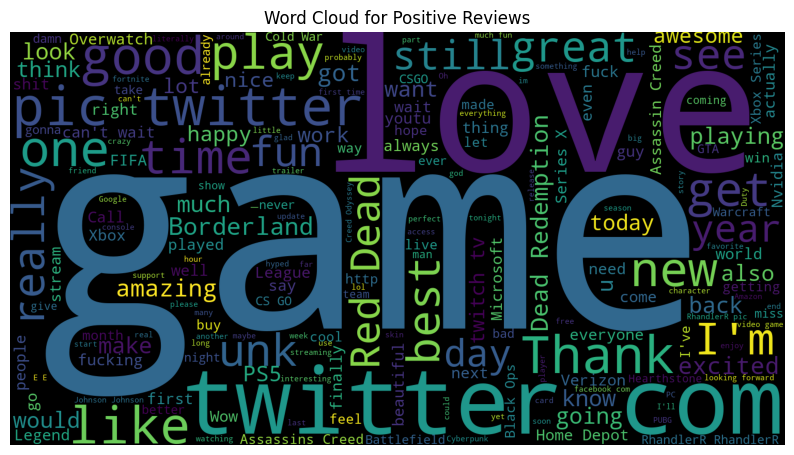

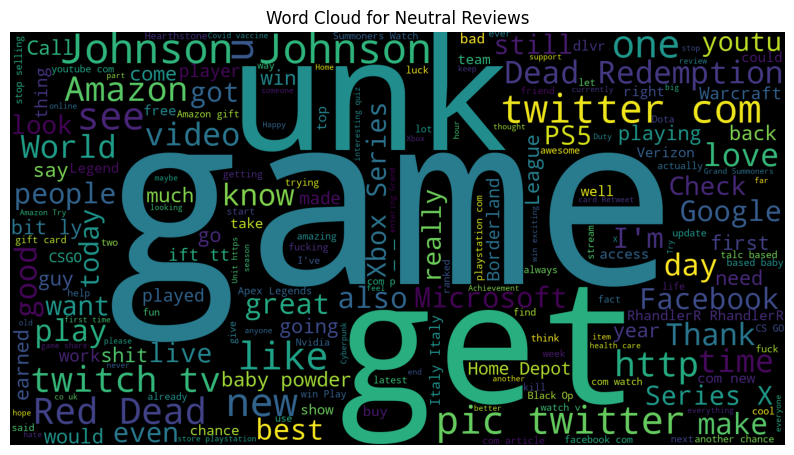

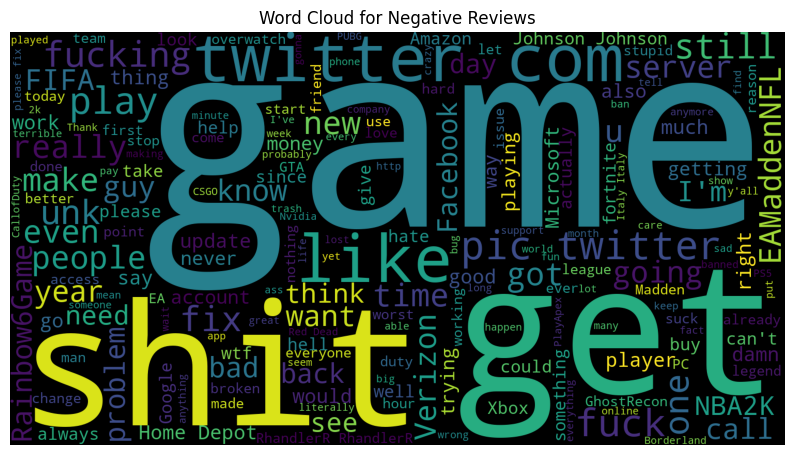

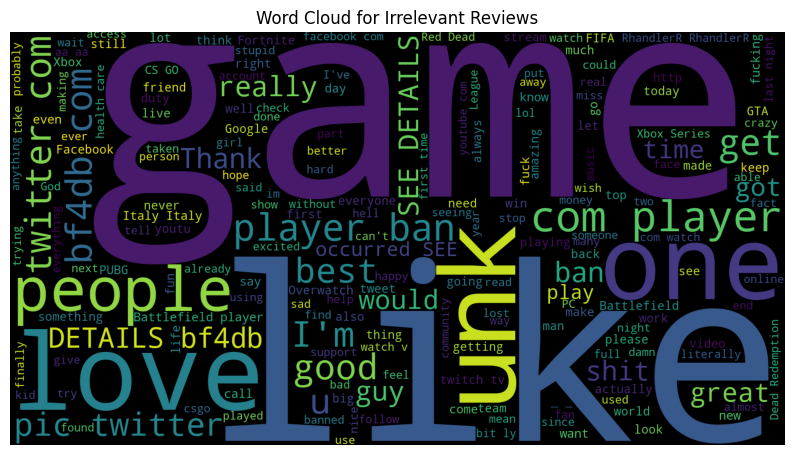

In [37]:
for mode in df["Mode"].unique():
    plot_wordcloud(df, mode)

In [38]:
df.head()

,Index,Land,Mode,Text,cleaned_text,sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,get borderland kill,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,come borderland murder,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,get borderland 2 murder,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,get borderland murder,2


In [41]:
## word frequency analysis
def plot_most_common_words(df, top_n=10):
    for mode in df["Mode"].unique():
        sub_df = df[df["Mode"] == mode]
        corpus = " ".join(sub_df["cleaned_text"].values)
        corpus = [ word for word in corpus.split(" ")]
        most_common_words = Counter(corpus).most_common()
        x = [item[0] for item in most_common_words[:top_n]]
        y = [item[1] for item in most_common_words[:top_n]]
        sns.barplot(x=y, y=x, orient="h")
        plt.title(f"{mode} Most Common Words")
        plt.show()

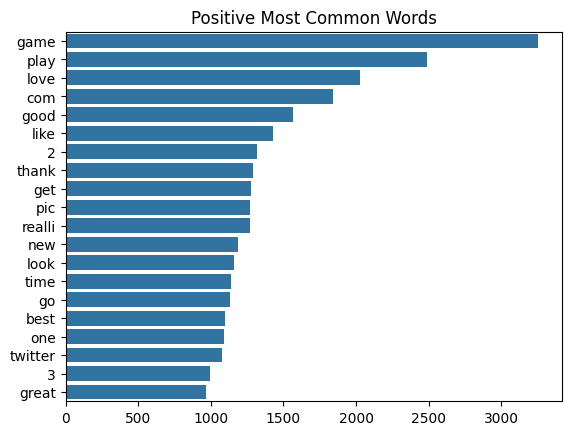

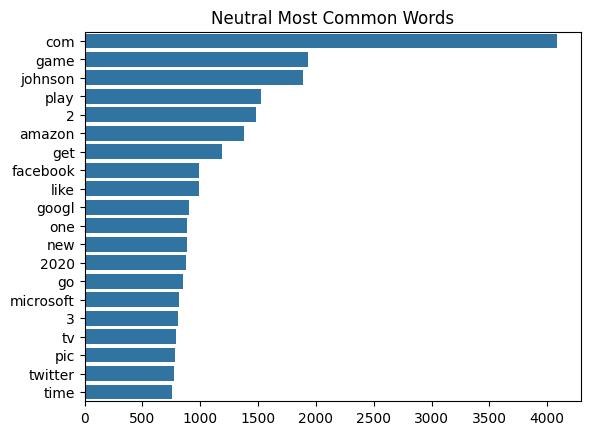

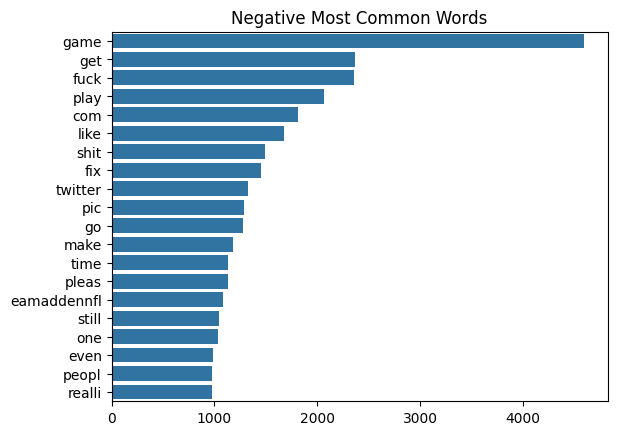

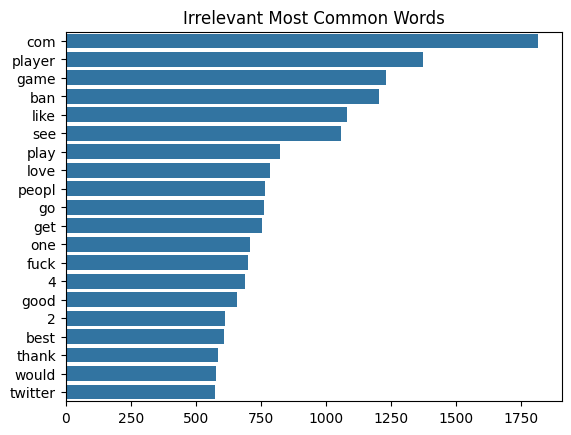

In [42]:
plot_most_common_words(df, 20)

In [103]:
df.shape

(69914, 6)

## Embedding Matrix

In [104]:
# Tokenization with limited vocabulary size for efficiency
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(df.cleaned_text)
tokenizer.fit_on_texts(df.cleaned_text)


In [105]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])

    return data

In [106]:
# glove_path = '../../../package/glove.6B/./data/glove.6B.50d.txt'
import numpy as np
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(glove_path, gensim_glove_path)
# gensim_model = KeyedVectors(gensim_glove_path)

def create_embedding_matrix(word_index, embedding_dict):

    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, 300), dtype=np.float32)
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]

    return embedding_matrix


glove_path = "../../../package/glove.6B/glove.6B.300d.txt"
# gensim_model = KeyedVectors.load_word2vec_format(gensim_glove_path)
embedding_dict = load_vectors(glove_path)
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict)
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.0062312,  1.0851   , -0.17238  , ..., -0.30437  ,  0.23297  ,
        -0.42836  ],
       [ 0.039064 ,  0.34595  ,  0.11547  , ..., -0.2009   ,  0.30849  ,
        -0.27548  ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [107]:
embedding_matrix.shape

(23612, 300)

In [108]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text', 'cleaned_text', 'sentiment'], dtype='object')

In [109]:
df.sample(10)["cleaned_text"].values

array(['valveso csgo csgo fill load peopl confus pleas suppli protect someth els peopl use paid hacker onlin game fuck valv someth human',
       'train style slow nvidia releas stylegan 3 train hour',
       'homedepot chickfila cocacola 234 million would give 1170 atlanta polic offic 200k take year start gofundm util market depart spread messag cover rest someon need put stop nonsens',
       'hot dog second best red run cross club come number 1 iykyk',
       'rockstargam everyon make gta5 great shit fix thing red dead redempt 2 suck fuck cock',
       'pubg mobil phone ban india 5 controversi preced game paper li e 1475927417 r',
       'verizon full shit lose servic somewher everi day',
       'aphelio got 223 ban leagu legend tournament championofgam com aphelio get',
       'declar battleground 3 instead bad compani 3 like dike want lose money',
       '35 borderland fuckin trash'], dtype=object)

## Creating Datasets

In [ ]:
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader

MAX_LEN = 167
BATCH_SIZE = 32

y = df.sentiment.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)


# 🔹 Convert texts to sequences and pad them
def preprocess_texts(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

xtrain = preprocess_texts(train_df.cleaned_text, tokenizer, MAX_LEN)
xtest = preprocess_texts(test_df.cleaned_text, tokenizer, MAX_LEN)


# 🔹 Custom PyTorch Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, text, sentiment):
        self.text = torch.tensor(text, dtype=torch.long)
        self.sentiment = torch.tensor(sentiment, dtype=torch.long)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return {'text': self.text[idx], 'target': self.sentiment[idx]}

# 🔹 Function to Create DataLoaders
def create_dataloader(texts, sentiment, batch_size):
    dataset = SentimentDataset(texts, sentiment)
    return DataLoader(dataset, batch_size=batch_size, drop_last=True)

# 🔹 Create DataLoaders
train_loader = create_dataloader(xtrain, train_df.sentiment.values, BATCH_SIZE)
valid_loader = create_dataloader(xtest, test_df.sentiment.values, BATCH_SIZE)


In [111]:
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[   0,    0,    0,  ..., 5677,  115,  208],
         [   0,    0,    0,  ...,   34,   79,   24],
         [   0,    0,    0,  ...,   19,  217,  998],
         ...,
         [   0,    0,    0,  ..., 1519,  237, 6253],
         [   0,    0,    0,  ...,   40, 4438, 2908],
         [   0,    0,    0,  ...,  123, 7530, 7531]]),
 'target': tensor([2, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 2, 1, 0, 2])}

In [112]:
for i in range(10):
    print(train_df["cleaned_text"].iloc[i])


lit play creat distanc fortitud instantli let relax sight alert look forward differ avenu well done
real gamer got gta shit
look pretti promis
smh accept way easport mut like dont care ago racism someth goe c
nice knife
wtf
anyon anyon know liter god black op 1 cant wait
skin age well localpolarbear
realdonaldtrump thank american peopl weight univers shoulder hate peopl show appreci beauti choic one man made one favorit q post
hello


## Modeling

In [113]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Current device is {device}')

Current device is cpu


In [114]:

hidden_dim = 64
output_size = 3

class SentimentBiLSTM(nn.Module):
    """BiLSTM model for sentiment analysis using pretrained embeddings."""

    def __init__(self, embedding_matrix, hidden_dim, output_size):
        super(SentimentBiLSTM, self).__init__()

        num_words, embed_dim = embedding_matrix.shape

        # Initialize the embedding layer with pre-trained weights (frozen)
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True
        )

        # Define bidirectional LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)

        # Fully connected layer (2 * hidden_dim because of bidirectional LSTM)
        self.fc = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, x):
        """Forward pass of the BiLSTM model."""
        x = self.embedding(x)  # Embedding lookup
        lstm_out, _ = self.lstm(x)  # BiLSTM layer
        lstm_out = lstm_out[:, -1, :]  # Get the last time step's output
        out = self.fc(lstm_out)  # Fully connected layer
        return out




In [115]:
model = SentimentBiLSTM(embedding_matrix , hidden_dim, output_size)
model = model.to(device)
print(model)

SentimentBiLSTM(
  (embedding): Embedding(23612, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Gradient clipping value
CLIP = 5
EPOCHS = 9
valid_loss_min = np.Inf

# Track loss and accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Accuracy function
def accuracy(pred, label):
    return (pred.argmax(1) == label.squeeze()).sum().item()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss, epoch_train_acc = 0, 0
    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data['text'].to(device, dtype=torch.long), data['target'].to(device, dtype=torch.long)
            VOCAB_SIZE = len(tokenizer.word_index) + 1

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)  # Prevent exploding gradients
            optimizer.step()

            # Accumulate loss and accuracy
            epoch_train_loss += loss.item()
            epoch_train_acc += accuracy(outputs, labels)
            # Update progress bar description with loss and accuracy
            pbar.set_postfix(loss=epoch_train_loss / (batch_idx + 1), accuracy=epoch_train_acc / (batch_idx + 1))

    # Compute mean train loss & accuracy
    epoch_train_loss /= len(train_loader)
    epoch_train_acc /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    epoch_val_loss, epoch_val_acc = 0, 0

    with tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        with torch.no_grad():
            for batch_idx, data in enumerate(valid_loader):
                inputs, labels = data['text'].to(device, dtype=torch.long), data['target'].to(device, dtype=torch.long)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate validation loss and accuracy
                epoch_val_loss += loss.item()
                epoch_val_acc += accuracy(outputs, labels)
                pbar.set_postfix(loss=epoch_val_loss / (batch_idx + 1), accuracy=epoch_val_acc / (batch_idx + 1))

    # Compute mean validation loss & accuracy
    epoch_val_loss /= len(valid_loader)
    epoch_val_acc /= len(valid_loader.dataset)

    # Store values for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    # Logging
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc*100:.2f}%")

    # Save model if validation loss improves
    if epoch_val_loss < valid_loss_min:
        print(f"📉 Validation loss decreased ({valid_loss_min:.6f} → {epoch_val_loss:.6f}). Saving model...")
        # torch.save(model.state_dict(), "best_model.pt")
        valid_loss_min = epoch_val_loss

    print("=" * 60)



Training Epoch 1/9:   0%|          | 0/1747 [00:00<?, ?batch/s]

Validation Epoch 1/9:   0%|          | 0/436 [00:22<?, ?batch/s, accuracy=21.2, loss=0.764]


Epoch [1/9]
Train Loss: 0.8544 | Train Acc: 59.68%
Val   Loss: 0.7637 | Val   Acc: 65.95%
📉 Validation loss decreased (inf → 0.763688). Saving model...


Training Epoch 2/9:   0%|          | 0/1747 [02:36<?, ?batch/s, accuracy=22.1, loss=0.699]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_train_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_train_acc)
plt.plot(range(1,10),epoch_val_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_val_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()